In [100]:
import os
from pathlib import Path
import pandas as pd

import trompy as tp

%run "..//src//vgp_helper_fx"

In [101]:
ROOT_FOLDER = Path("D:\\TestData\\2photon")

DATA_FOLDER = ROOT_FOLDER / "VGP_procd_data_22-12-05"
BEHAV_FOLDER = ROOT_FOLDER / "bonsai" / "behav"
METAFILE = DATA_FOLDER / "metafile_vgp.csv"


In [102]:
metafile = pd.read_csv(METAFILE)

In [103]:
len(metafile)

440

In [104]:
metafile.columns

Index(['animal', 'date', 'day', 'phase', 'solution', 'eventfile', 'framefile',
       'licks', 'scanimagefile', 'folder', 'diet', 'session', 'Ses',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [107]:
def convert_date(date_string):
    
    d,m,y = date_string.split("/")
    
    return ("").join([y,m,d])


def make_licks_df(row):
    
    # key=row[0]+'_'+row[1]
    animal=row.animal.item()
    day=str(row.day.item()).zfill(3)
    date_from_metafile=str(row.date.item())

    date = convert_date(date_from_metafile)
    
    s2p_folder = DATA_FOLDER / f"sub-{animal}" / f"ses-{day}-{date}" / "suite2p" / "plane0"
    events_file = BEHAV_FOLDER / f"sub-{animal}" / f"ses-{day}-{date}" / f"sub-{animal}_ses-{day}_events.csv"
    
    print(s2p_folder)
    
    d = assemble_data(s2p_folder,events_file)
    
    return d["lick_snips_all"]

row = metafile.query("animal == 'VGP118' and solution == 'Cas' and session == 'S2' and diet == 'PR'")

print(len(row))

d = make_licks_df(row)

1
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP118\ses-025-20221006\suite2p\plane0


In [108]:
# get rows for selected mice and dates

mice = metafile.animal.unique()
solution = "Cas"
diet = "PR"
session ="S2"

dfs = []

for mouse in mice:
    animal_data = metafile.query("animal == @mouse")
    row = metafile.query("animal == @mouse and solution == @solution and diet == @diet and session == @session")
    if len(row) > 0: # tests if there is any data in row, if there is not probably because NR mouse
        dfs.append(make_licks_df(row))
        


D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP118\ses-025-20221006\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP203\ses-029-20221010\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP302\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP306\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP307\ses-038-20221118\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP402\ses-030-20230320\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP505\ses-037-20230418\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP506\ses-037-20230418\suite2p\plane0
D:\TestData\2photon\VGP_procd_data_22-12-05\sub-VGP509\ses-037-20230418\suite2p\plane0


In [116]:
cell_averages = []
for df in dfs:
    print(df.shape)
    tmp = np.mean(df, axis=1)
    cell_averages.append(tmp)
    print(tmp.shape)
    
all_cells = np.concatenate(cell_averages)

(30, 16, 150)
(30, 150)
(48, 4, 150)
(48, 150)
(80, 17, 150)
(80, 150)
(19, 8, 150)
(19, 150)
(28, 18, 150)
(28, 150)
(29, 7, 150)
(29, 150)
(34, 18, 150)
(34, 150)
(42, 14, 150)
(42, 150)
(26, 12, 150)
(26, 150)


In [117]:
all_cells.shape

(336, 150)

In [122]:
### Code from Vijay to try spectral analysis - from Kheirbek lab

In [123]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import subprocess
import time
import pandas
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import sys
import re

In [124]:
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

In [127]:
def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

def tsplot(ax, data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    ax.plot(x,est,**kw)
    ax.margins(x=0)

In [118]:
populationdata = all_cells

In [120]:
framerate = 10
pre_window_size = 5*framerate # 3 seconds multipled by 5 frames. Corresponds to baseline prior to cues.
window_size = 100 # Total number of frames plotted around a cue
frames_to_reward = 3*framerate # 3 seconds until reward after CS+

sortwindow = [pre_window_size, pre_window_size + frames_to_reward] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['CS+', 'CS-']

C:\Users\jmc010\AppData\Local\Temp\ipykernel_25112\795295410.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


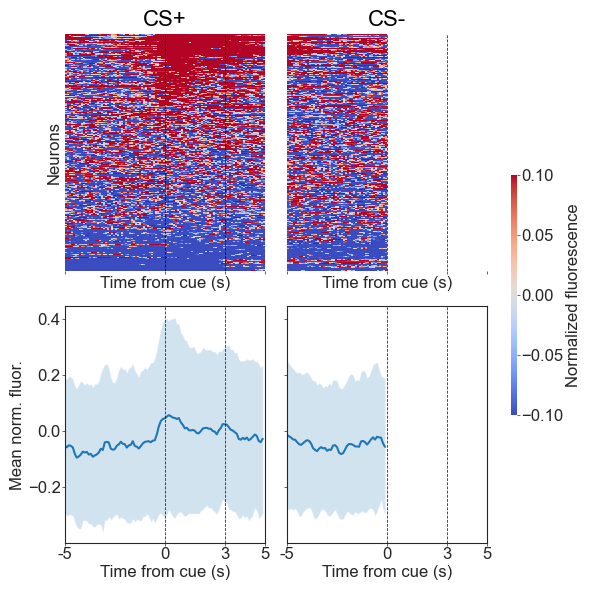

In [129]:
fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('coolwarm'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    ax.set_yticks([])
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    
        
    ax = axs[1,t]
    tsplot(ax, populationdata[sortresponse, t*window_size:(t+1)*window_size],
              )
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from cue (s)')
    ax.set_xticks([0, pre_window_size, pre_window_size + frames_to_reward, window_size]) 
    ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                     for a in [0, pre_window_size,
                                               pre_window_size + frames_to_reward, window_size]])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')

fig.tight_layout()
fig.subplots_adjust(right=0.82)

Number of PCs = 150
Number of PCs to keep = 6


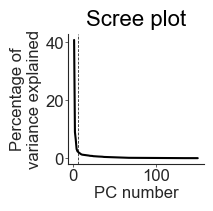

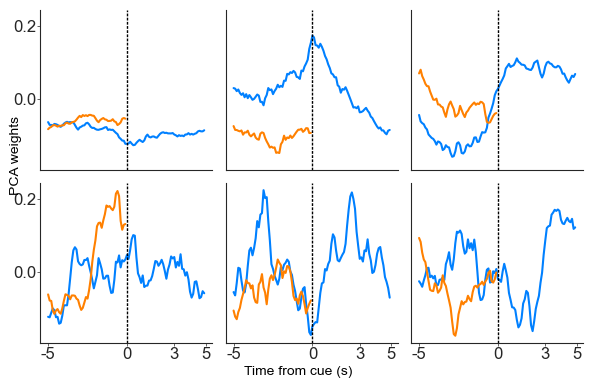

In [147]:
load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(ROOT_FOLDER, 'pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(ROOT_FOLDER, 'OFCCaMKII_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
with open(os.path.join(ROOT_FOLDER, 'transformed_data.pickle'), 'wb') as f:
        pickle.dump(transformed_data, f)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
#[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['CS+'] = (0,0.5,1)
colors_for_key['CS-'] = (1,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1)
    # ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
    #            textcoords='axes fraction', multialignment='center', size='large')
    if pc >= num_retained_pcs-numcols:
        ax.set_xticks([0, pre_window_size,
                       pre_window_size + frames_to_reward, window_size])
        ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                             for a in [0, pre_window_size,
                                       pre_window_size + frames_to_reward, window_size]])
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    # [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from cue (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

In [148]:
transformed_data

array([[ 1.71127447,  2.31623542, -1.08526204, ..., -0.36932397,
        -0.19115985,  0.43406985],
       [ 0.70113411,  1.42994871, -0.47679619, ..., -1.12406005,
        -0.12863478, -2.29401662],
       [ 0.93670597,  1.15071122,  0.43031088, ...,  0.15227238,
         1.24794379,  1.04534204],
       ...,
       [-0.07344796, -0.79029816, -0.37116237, ...,  0.20962149,
        -0.2818755 ,  1.86443882],
       [-0.48329202,  0.62686598, -0.08849386, ...,  1.73201812,
        -2.2370512 , -0.02589724],
       [-1.50997795,  0.34779636, -0.41239652, ..., -0.63655689,
         0.0550583 , -0.2622726 ]])

In [149]:
max_n_clusters = 11 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([10, 20, 50, 100, 200]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print('Done with model fitting')

Done with numclusters = 2, num nearest neighbors = 10: score = 0.106
Done with numclusters = 2, num nearest neighbors = 20: score = 0.254
Done with numclusters = 2, num nearest neighbors = 50: score = 0.251
Done with numclusters = 2, num nearest neighbors = 100: score = 0.257
Done with numclusters = 2, num nearest neighbors = 200: score = 0.162
Done with numclusters = 3, num nearest neighbors = 10: score = 0.186
Done with numclusters = 3, num nearest neighbors = 20: score = 0.231
Done with numclusters = 3, num nearest neighbors = 50: score = 0.267
Done with numclusters = 3, num nearest neighbors = 100: score = 0.267
Done with numclusters = 3, num nearest neighbors = 200: score = 0.158
Done with numclusters = 4, num nearest neighbors = 10: score = 0.163
Done with numclusters = 4, num nearest neighbors = 20: score = 0.213
Done with numclusters = 4, num nearest neighbors = 50: score = 0.272
Done with numclusters = 4, num nearest neighbors = 100: score = 0.266
Done with numclusters = 4, nu

In [150]:
temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(ROOT_FOLDER, 'silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f)

In [151]:
with open(os.path.join(ROOT_FOLDER, 'silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
# transformed_data = np.load(os.path.join(ROOT_FOLDER, 'transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters)

# model = AgglomerativeClustering(n_clusters=9,
#                                 affinity='l1',
#                                 linkage='average')

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
# with open(os.path.join(basedir, 'clusteringmodel.pickle'), 'wb') as f:
#     pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

# np.save(os.path.join(basedir, 'OFCCaMKII_clusterlabels.npy'), newlabels)

colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

7 50
Number of clusters = 7, average silhouette = 0.303


In [152]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

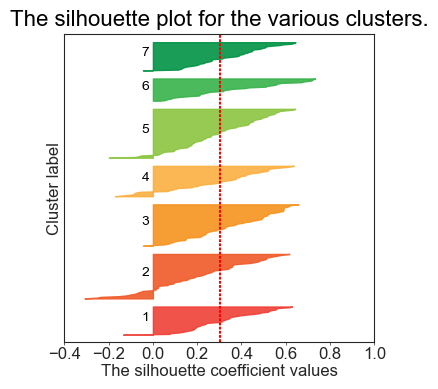

In [153]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

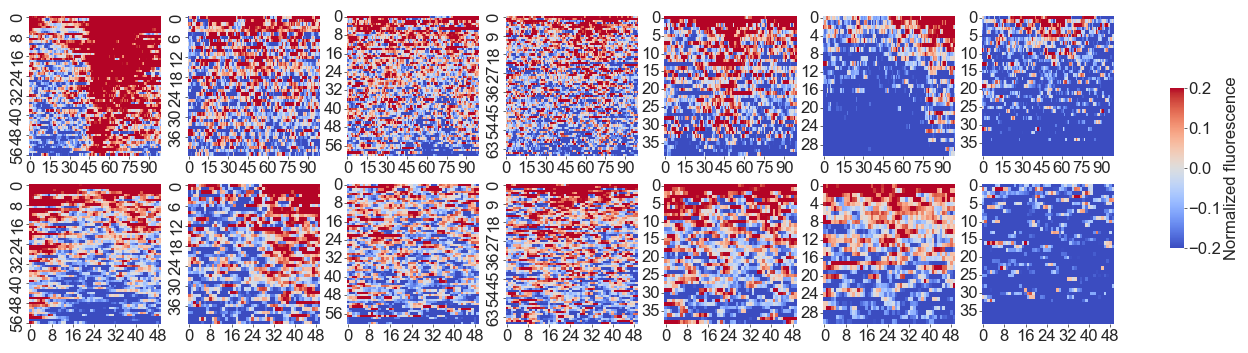

In [156]:
cmax = 0.2
sortwindow = [15, 100]

fig, axs = plt.subplots(len(trial_types),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(trial_types)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for k, tempkey in enumerate(trial_types):
        temp = populationdata[np.where(newlabels==cluster)[0], k*window_size:(k+1)*window_size]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[k, cluster],
                    cmap=plt.get_cmap('coolwarm'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[k, cluster].grid(False)
        

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (4).

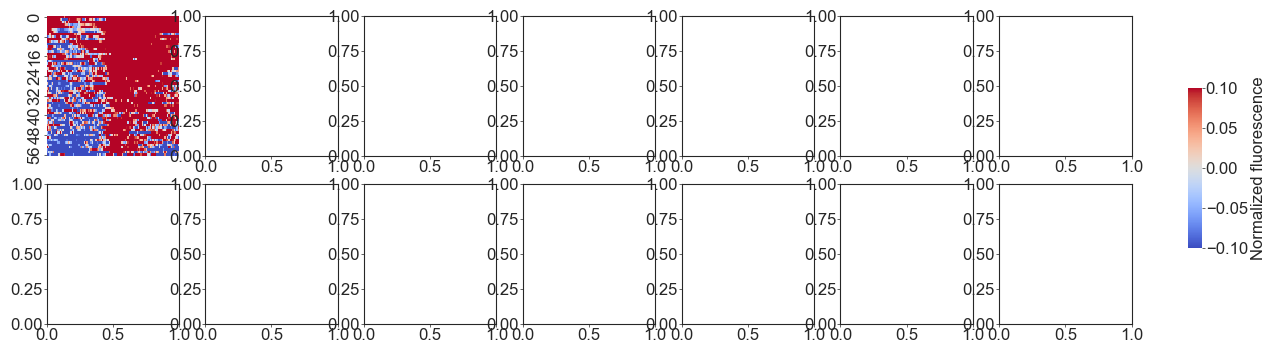

In [154]:
        if k==len(trial_types)-1:
            axs[k, cluster].set_xticks([0, pre_window_size,
                                        pre_window_size + frames_to_reward, window_size])
        else:
            axs[k, cluster].set_xticks([])
        axs[k, cluster].tick_params(width=0.5)    
        axs[k, cluster].set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
                                         for a in [0, pre_window_size,
                                                   pre_window_size + frames_to_reward, window_size]])
        axs[k, cluster].set_yticks([])
        axs[k, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)
        axs[k, cluster].axvline(pre_window_size + frames_to_reward, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[k, 0].set_ylabel('%s\nNeurons'%(tempkey))
    axs[0, cluster].set_title('Cluster %d\n(n=%d)'%(cluster+1, numroisincluster[c]))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)

In [88]:
snips = d["lick_snips_all"]

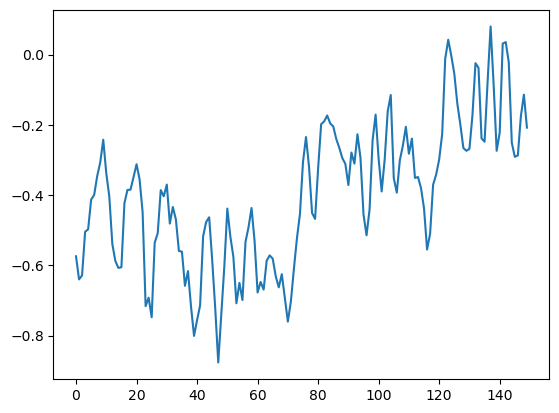

In [97]:
import matplotlib.pyplot as plt

plt.plot(np.mean(snips[9,:,:], axis=0))

In [ ]:
# Goes through metafile assembling data from s2p files where possible

cell_data={}

for row in rows:
    try:
        key=row[0]+'_'+row[1]
        animal=row[0]
        day=row[1]
        date=int(row[3])
        
        s2p_folder = os.path.join(DATA_FOLDER, "sub-{}\\ses-{}".format(animal, day))
        events_file = os.path.join(BEHAV_FOLDER, "sub-{0}\\ses-{1}-{2}\\sub-{0}_ses-{1}_events.csv".format(animal, day, date))
        
        cell_data[key] = assemble_data(s2p_folder,events_file)
        cell_data[key]['animal'] = row[0]
        cell_data[key]['diet'] = row[4]
        cell_data[key]['solution'] = row[2]
        
    except FileNotFoundError:
        print('Cannot find file for', key)